# Propagation des incertitudes

In [1]:
from retraites.SimulateurRetraites import SimulateurRetraites
from retraites.ModelePensionProbabiliste import ModelePensionProbabiliste
import openturns as ot
import pylab as pl
import scipy as sp
import numpy as np
import openturns.viewer as otv

## Définition des paramètres

In [2]:
simulateur = SimulateurRetraites()

## Définition du modèle

In [3]:
S = 0.0
D = 0.14
annee = 2050
modele = ModelePensionProbabiliste(simulateur, annee, S, D)

Nous souhaitons probabiliser les variables suivantes :
* $A_s$ : l'âge moyen de départ à la retraite défini par l'utilisateur
* $F$ : facteur d'élasticité de report de l'âge de départ (par défaut, $F = 0.5$)
* $\tau_c$ : le taux de chômage

Le solde financier $S_s$ est fixé à zéro et le niveau de dépense $D_s$ à 14% du PIB. Analysons dans ces conditions la sensibilité du niveau de pension $P_s$  à l'âge moyen de départ à la retraite $A_s$, au facteur d'élasticité $F$ et au taux de chômage $\tau_c$.

In [4]:
fonctionPension = modele.getFonction()
fonctionPension

class=FunctionImplementation name=Unnamed description=[As,F,TauC,P] evaluationImplementation=class=ParametricEvaluation function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[S,D,As,F,TauC,P] evaluationImplementation=class=PythonEvaluation name=FonctionPension description=[S,D,As,F,TauC,P] parameter=class=Point name=Unnamed dimension=0 values=[] gradientImplementation=class=CenteredFiniteDifferenceGradient name=Unnamed epsilon=class=Point name=Unnamed dimension=5 values=[1e-05,1e-05,1e-05,1e-05,1e-05] evaluation=class=PythonEvaluation name=FonctionPension description=[S,D,As,F,TauC,P] parameter=class=Point name=Unnamed dimension=0 values=[] hessianImplementation=class=CenteredFiniteDifferenceHessian name=Unnamed epsilon=class=Point name=Unnamed dimension=5 values=[0.0001,0.0001,0.0001,0.0001,0.0001] evaluation=class=PythonEvaluation name=FonctionPension description=[S,D,As,F,TauC,P] parameter=class=Point name=Unnamed dimension=0 values=[] parameters positions=[0,1] parameters=class=PointWithDescription name=Unnamed dimension=2 description=[S,D] values=[0,0.14] input positions=[2,3,4] gradientImplementation=class=ParametricGradient evaluation=class=ParametricEvaluation function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[S,D,As,F,TauC,P] evaluationImplementation=class=PythonEvaluation name=FonctionPension description=[S,D,As,F,TauC,P] parameter=class=Point name=Unnamed dimension=0 values=[] gradientImplementation=class=CenteredFiniteDifferenceGradient name=Unnamed epsilon=class=Point name=Unnamed dimension=5 values=[1e-05,1e-05,1e-05,1e-05,1e-05] evaluation=class=PythonEvaluation name=FonctionPension description=[S,D,As,F,TauC,P] parameter=class=Point name=Unnamed dimension=0 values=[] hessianImplementation=class=CenteredFiniteDifferenceHessian name=Unnamed epsilon=class=Point name=Unnamed dimension=5 values=[0.0001,0.0001,0.0001,0.0001,0.0001] evaluation=class=PythonEvaluation name=FonctionPension description=[S,D,As,F,TauC,P] parameter=class=Point name=Unnamed dimension=0 values=[] parameters positions=[0,1] parameters=class=PointWithDescription name=Unnamed dimension=2 description=[S,D] values=[0,0.14] input positions=[2,3,4] hessianImplementation=class=ParametricHessian evaluation=class=ParametricEvaluation function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[S,D,As,F,TauC,P] evaluationImplementation=class=PythonEvaluation name=FonctionPension description=[S,D,As,F,TauC,P] parameter=class=Point name=Unnamed dimension=0 values=[] gradientImplementation=class=CenteredFiniteDifferenceGradient name=Unnamed epsilon=class=Point name=Unnamed dimension=5 values=[1e-05,1e-05,1e-05,1e-05,1e-05] evaluation=class=PythonEvaluation name=FonctionPension description=[S,D,As,F,TauC,P] parameter=class=Point name=Unnamed dimension=0 values=[] hessianImplementation=class=CenteredFiniteDifferenceHessian name=Unnamed epsilon=class=Point name=Unnamed dimension=5 values=[0.0001,0.0001,0.0001,0.0001,0.0001] evaluation=class=PythonEvaluation name=FonctionPension description=[S,D,As,F,TauC,P] parameter=class=Point name=Unnamed dimension=0 values=[] parameters positions=[0,1] parameters=class=PointWithDescription name=Unnamed dimension=2 description=[S,D] values=[0,0.14] input positions=[2,3,4]

In [5]:
inputDescription = fonctionPension.getInputDescription()
inputDescription

[As,F,TauC]

In [6]:
fonctionPension.getOutputDescription()

[P]

In [7]:
fonctionPension.getParameterDescription()

[S,D]

In [8]:
inputDistribution = modele.getInputDistribution()
inputDimension = inputDistribution.getDimension()
inputDimension

3

In [9]:
for i in range(inputDimension):
    print(inputDescription[i], inputDistribution.getMarginal(i))

As Uniform(a = 62, b = 66)
F Uniform(a = 0.25, b = 0.75)
TauC Uniform(a = 4.5, b = 10)


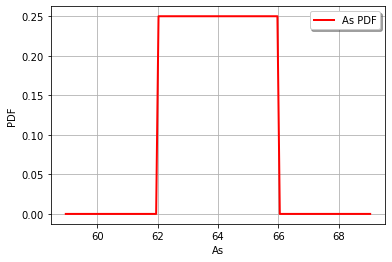

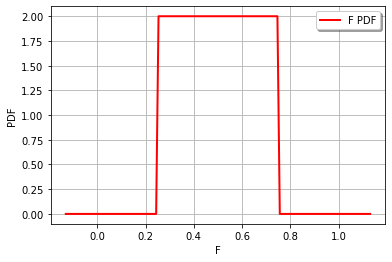

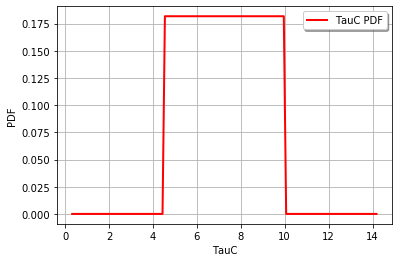

In [10]:
for i in range(inputDimension):
    marginale = inputDistribution.getMarginal(i)
    view = otv.View(marginale.drawPDF())

## Analyse en tendance centrale

In [11]:
inputRandomVector = ot.RandomVector(inputDistribution)
outputRandomVector = ot.CompositeRandomVector(fonctionPension, inputRandomVector)

In [12]:
sampleSize = 10000
sampleP = outputRandomVector.getSample(sampleSize)

In [13]:
kernel = ot.KernelSmoothing()
fittedDist = kernel.build(sampleP)

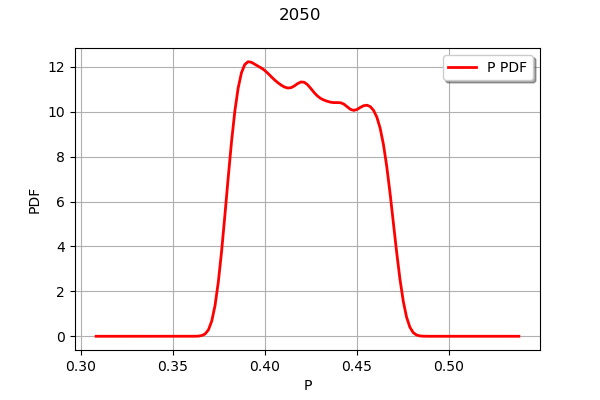

In [14]:
graph = fittedDist.drawPDF()
graph.setTitle("%d" % (annee))
graph

## Sensibilité à l'année

In [15]:
def createHSVColor(indexCurve,maximumNumberOfCurves):
    '''Create a HSV color for the indexCurve-th curve
    from a sample with maximum size equal to maximumNumberOfCurves'''
    color = ot.Drawable.ConvertFromHSV(indexCurve * 360.0/maximumNumberOfCurves, 1.0, 0.9)
    return color

2020
2030
2040
2050
2070


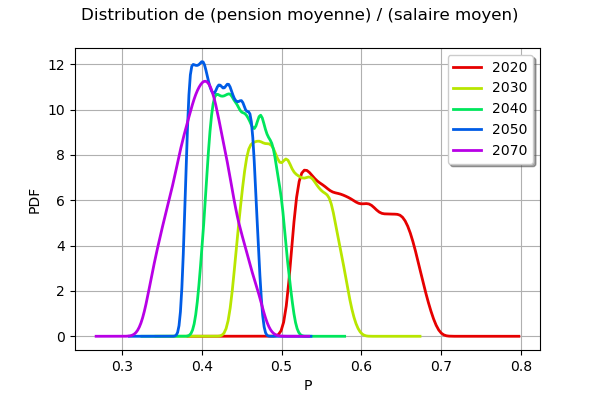

In [16]:
S = 0.0
D = 0.14
title = "Distribution de (pension moyenne) / (salaire moyen)"
xTitle = "P"
yTitle = "PDF" 
showAxes = True
graph = ot.Graph(title, xTitle, yTitle, showAxes)
sampleSize = 10000
table_annees = [2020, 2030, 2040, 2050, 2070]
nb_annees = len(table_annees)
for i in range(nb_annees):
    a = table_annees[i]
    print(a)
    modele = ModelePensionProbabiliste(simulateur, a, S, D)
    inputDistribution = modele.getInputDistribution()
    fonctionPension = modele.getFonction()
    inputRandomVector = ot.RandomVector(inputDistribution)
    outputRandomVector = ot.CompositeRandomVector(fonctionPension, inputRandomVector)
    sampleP = outputRandomVector.getSample(sampleSize)
    kernel = ot.KernelSmoothing()
    fittedDist = kernel.build(sampleP)
    pdfP = fittedDist.drawPDF()
    pdfP.setColors([createHSVColor(i,nb_annees)])
    graph.add(pdfP)
graph.setLegends([str(a) for a in table_annees])
graph.setLegendPosition("topright")
graph